# What will affect taxi drivers’ profit?

In [1]:
import pandas as pd
import warnings
import numpy as np
import geopandas as gpd

warnings.filterwarnings("ignore")

import folium
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster

import scipy
import scipy.cluster.hierarchy as sch

import seaborn as sns

In [2]:
#https://wil.yegelwel.com/cluster-correlation-matrix/


def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

## =====Preprocessing=====

In [3]:
# Read the inital Data set
yellow_09 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-09.csv")

In [4]:
# Overview the dateset
yellow_09

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               1  2018-09-01 00:01:35   2018-09-01 00:09:48                2   
1               1  2018-09-01 00:22:22   2018-09-01 00:28:55                1   
2               1  2018-09-01 00:38:10   2018-09-01 00:44:42                1   
3               1  2018-09-01 00:46:36   2018-09-01 00:54:49                1   
4               1  2018-09-01 00:59:46   2018-09-01 01:02:41                1   
...           ...                  ...                   ...              ...   
8040128         2  2018-09-30 23:06:44   2018-09-30 23:12:40                1   
8040129         2  2018-09-30 23:15:34   2018-09-30 23:18:31                1   
8040130         2  2018-09-30 23:32:19   2018-09-30 23:41:33                2   
8040131         2  2018-09-30 23:03:59   2018-09-30 23:14:09                1   
8040132         2  2018-09-30 23:53:22   2018-09-30 23:54:33                1   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
0                 1.50           1                  N           161   
1                 1.00           1                  N           233   
2                 1.00           1                  N           164   
3                 1.90           1                  N            48   
4                 0.60           1                  N           262   
...                ...         ...                ...           ...   
8040128           1.07           1                  N           239   
8040129           0.75           1                  N           142   
8040130           2.42           1                  N           234   
8040131           1.99           1                  N           262   
8040132           0.48           1                  N           263   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0                 107             1          7.5    0.5      0.5        0.00   
1                 100             1          6.5    0.5      0.5        2.00   
2                 163             2          6.5    0.5      0.5        0.00   
3                 140             1          8.5    0.5      0.5        1.00   
4                 263             1          4.5    0.5      0.5        1.15   
...               ...           ...          ...    ...      ...         ...   
8040128           142             2          6.5    0.5      0.5        0.00   
8040129           163             1          4.5    0.5      0.5        1.74   
8040130           161             1          9.5    0.5      0.5        2.16   
8040131           238             1          9.5    0.5      0.5        0.00   
8040132           263             2          3.5    0.5      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  
0                 0.0                    0.3          8.80  
1                 0.0                    0.3          9.80  
2                 0.0                    0.3          7.80  
3                 0.0                    0.3         10.80  
4                 0.0                    0.3          6.95  
...               ...                    ...           ...  
8040128           0.0                    0.3          7.80  
8040129           0.0                    0.3          7.54  
8040130           0.0                    0.3         12.96  
8040131           0.0                    0.3         10.80  
8040132           0.0                    0.3          4.80  

[8040133 rows x 17 columns]

### Missing Value Detect

In [5]:
# Check if there are missing values
yellow_09.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

### Noisy Data Remove

In [6]:
# remove invaild data

# restricted data in the vaild time [Sep 2018]
cleaned_yellow_09 = yellow_09[(yellow_09["tpep_pickup_datetime"]<"2018-09-30 23:59:59") & (yellow_09["tpep_pickup_datetime"]>"2018-09-01 00:00:00")]
cleaned_yellow_09 = cleaned_yellow_09[(cleaned_yellow_09["tpep_dropoff_datetime"]<"2018-09-30 23:59:59") & (cleaned_yellow_09["tpep_dropoff_datetime"]>"2018-09-01 00:00:00")]

# remove passager == 0 ,
cleaned_yellow_09 = cleaned_yellow_09[(cleaned_yellow_09["passenger_count"] != 0)]

# trip_distance ==0, 
cleaned_yellow_09 = cleaned_yellow_09[cleaned_yellow_09["trip_distance"] != 0]
                                      
# We only focus on the data with tips recoreded 
cleaned_yellow_09 = cleaned_yellow_09[(cleaned_yellow_09["payment_type"] == 1)]
          
# total payment > 0
cleaned_yellow_09 = cleaned_yellow_09[(cleaned_yellow_09["fare_amount"] >= 2.5)]     
    
# total payment > 0
cleaned_yellow_09 = cleaned_yellow_09[(cleaned_yellow_09["total_amount"] >= 2.5)]   

### Outliers Detect and Remove

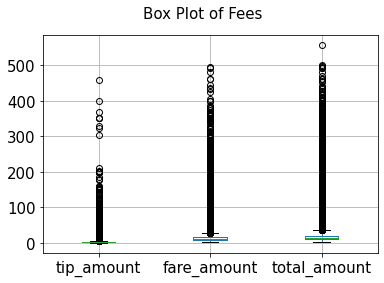

In [7]:
# initial view of fees
amount = ["tip_amount","fare_amount","total_amount"]

amount_boxplot = cleaned_yellow_09.boxplot(column=amount, fontsize=15,figsize=(6,4))
fig = amount_boxplot.get_figure()

fig.suptitle('Box Plot of Fees ',fontsize=15)
fig.show()
fig.savefig("initial view of tips amount.png")

In [8]:
# clean tips outliers

#https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles
Q1 = cleaned_yellow_09.quantile(0.25)
Q3 = cleaned_yellow_09.quantile(0.75)
IQR = Q3 - Q1

cleaned= cleaned_yellow_09[~((cleaned_yellow_09< (Q1 - 3 * IQR)) |(cleaned_yellow_09> (Q3 + 3 * IQR))).any(axis=1)]

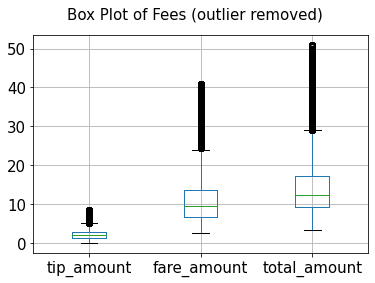

In [9]:
# show the tips after remove outliers
amount_boxplot = cleaned.boxplot(column=amount, fontsize=15,figsize=(6,4))
fig = amount_boxplot.get_figure()

fig.suptitle('Box Plot of Fees (outlier removed)',fontsize=15)
fig.show()
fig.savefig("tips amount after cleaning ourliers.png")

### Feature Engineering

In [10]:
# Creat a new column which only contains the pick up date
# Creat a new column which only contrains the pick up time
cleaned['date'] = cleaned['tpep_pickup_datetime'].str[5:10]
cleaned["Time_h"] = cleaned['tpep_pickup_datetime'].str[10:13]+":00"

In [11]:
# save to feather 
cleaned.reset_index().to_feather('18_cleaned_yellow_09.feather')

# =====Visualisation=====
## 1. What will increase the demand of taxi in New York?

In [12]:
full_month = pd.read_feather('18_cleaned_yellow_09.feather').drop('index', axis=1)

### Local Demand Increase?
### Sport Event

In [13]:
# https://www.usopen.org/index.html
# https://en.wikipedia.org/wiki/2015_US_Open_(tennis) (August 31 – September 13)


# Venue : USTA Billie Jean King National Tennis Center https://www.latlong.net/convert-address-to-lat-long.html

Venue_coord = [40.750366,-73.845612]
Venue_coordM = np.array(Venue_coord)
sf = gpd.read_file("E:/Uni/MAST30034/Data/taxi_zones/taxi_zones.shp")
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [14]:
men_single = full_month[(full_month["date"]=="09-09")]
women_single = full_month[(full_month["date"]=="09-08")]

#### Men's Single

In [15]:
DO_count = men_single['DOLocationID'].value_counts().sort_index()
DO_count = pd.DataFrame({"LocationID":DO_count.index,"DO_Count": DO_count})
gdf = gpd.GeoDataFrame(pd.merge(DO_count, sf, left_on='LocationID', right_on='LocationID')).drop('LocationID',axis=1)
#gdf['percentage']=gdf['DO_Count']/gdf["DO_Count"].sum()*100

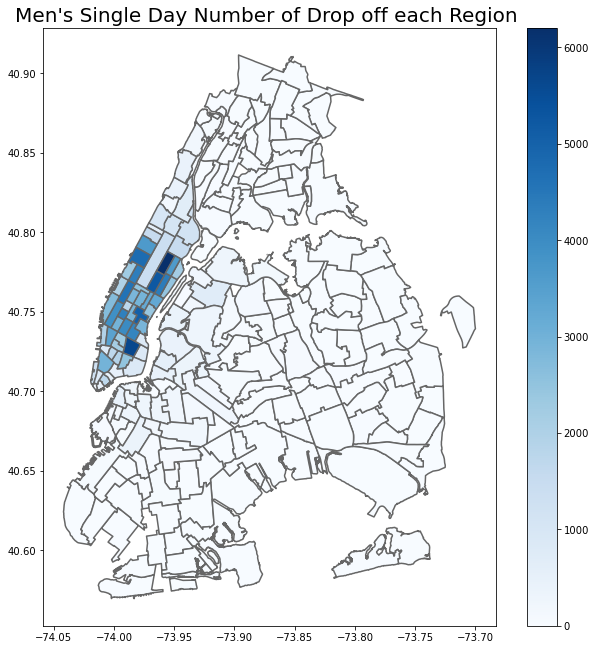

In [16]:
# set the value column that will be visualised
variable = 'DO_Count'
# set the range for the choropleth values
vmin, vmax = 0, gdf['DO_Count'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(11, 11))

# remove the axis
#ax.axis('off')

# add a title and annotation
ax.set_title("Men's Single Day Number of Drop off each Region ",  fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)


# create map
gdf.plot(column=variable, cmap='Blues', linewidth=1.5, ax=ax, edgecolor='0.4')
plt.savefig("Men's Single Day Number of Drop off each Region.png")
plt.show()


In [17]:
m = folium.Map(location=[40.74, -73.94], tiles=None, zoom_start=10)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)

# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=gdf,
    name='choropleth',
    data = gdf,
    columns=["OBJECTID","DO_Count"],
    key_on='feature.properties.OBJECTID',
     fill_opacity=1,
     line_opacity=0.3,
     legend_name='Mens Single Day Numbers of drop off'
).add_to(m)
feature = folium.FeatureGroup(name='<span style="color: blue;">Tennis Venue</span>').add_to(m)

folium.Marker(Venue_coord, popup='TUSTA Billie Jean King National Tennis Center',icon=folium.Icon(color='blue')).add_to(feature)

folium.map.LayerControl('topright', collapsed=False).add_to(m)


#folium.Circle(radius=600, location=Venue_coord,popup='TUSTA Billie Jean King National Tennis Center',color='#3186cc',fill=True,).add_to(m)
m.save('Mens_SingleChoroplethMap.html')
m

#### Women's Single

In [18]:
DO_count = women_single['DOLocationID'].value_counts().sort_index()
DO_count = pd.DataFrame({"LocationID":DO_count.index,"DO_Count": DO_count})
gdf = gpd.GeoDataFrame(pd.merge(DO_count, sf, left_on='LocationID', right_on='LocationID')).drop('LocationID',axis=1)
#gdf['percentage']=gdf['DO_Count']/gdf["DO_Count"].sum()*100

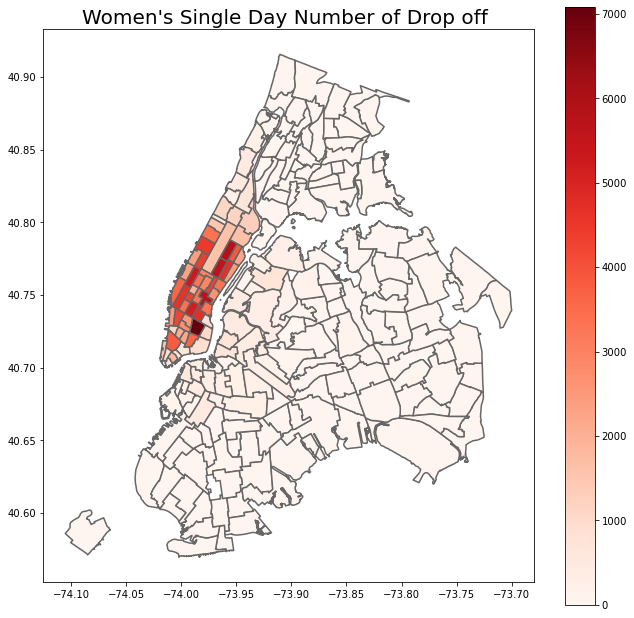

In [19]:
# set the value column that will be visualised
variable = 'DO_Count'
# set the range for the choropleth values
vmin, vmax = 0, gdf['DO_Count'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(11, 11))

# remove the axis
#ax.axis('off')

# add a title and annotation
ax.set_title("Women's Single Day Number of Drop off ",  fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)


# create map
gdf.plot(column=variable, cmap='Reds', linewidth=1.5, ax=ax, edgecolor='0.4')
plt.savefig("Women's Single Day : Percentage of Drop off.png")
plt.show()



In [20]:
m = folium.Map(location=[40.74, -73.94], tiles=None, zoom_start=10)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)

# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=gdf,
    name='choropleth',
    data = gdf,
    columns=["OBJECTID","DO_Count"],
    key_on='feature.properties.OBJECTID',
    fill_color='Reds',
     fill_opacity=1,
     line_opacity=0.3,
     legend_name='Womens Single Day Number of drop off'
).add_to(m)
feature = folium.FeatureGroup(name='<span style="color: red;">Tennis Venue</span>').add_to(m)
folium.Marker(Venue_coord, popup='TUSTA Billie Jean King National Tennis Center',icon=folium.Icon(color='red')).add_to(feature)

folium.map.LayerControl('topright', collapsed=False).add_to(m)


#folium.Circle(radius=600, location=Venue_coord,popup='TUSTA Billie Jean King National Tennis Center',color='#3186cc',fill=True,).add_to(m)
m.save('Womens_SingleChoroplethMap.html')
m

##### The Sport Event did not bring a significant increasing of demand around the venue

### Overall Demand Increase?

In [21]:
date_count = full_month['date'].value_counts().sort_index()
labels = date_count.index
x = np.arange(len(labels))  # the label locations

width = 0.35

#### 1.Sports Event


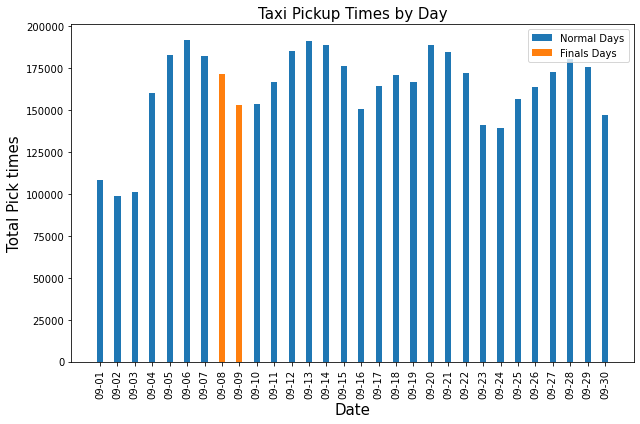

In [22]:
# high light the final days
final_bar_count = date_count.copy()
for i in range(len(final_bar_count)):
    if final_bar_count.index[i] not in ['09-08', '09-09']:
        final_bar_count[final_bar_count.index[i]] = 0


fig, ax = plt.subplots(figsize=(9,6))
normal_bar = ax.bar(x, date_count, width, label='Normal Days')
final_bar = ax.bar(x, final_bar_count, width, label='Finals Days')

#rects1[0].set_color('r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Pick times',fontsize=15)
ax.set_title('Taxi Pickup Times by Day',fontsize=15)
ax.set_xticks(x)
ax.set_xlabel('Date',fontsize=15)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=90)

fig.tight_layout()

plt.show()
fig.savefig('Taxi Pickup Times by Day Fianl.png')

### 2. Weather

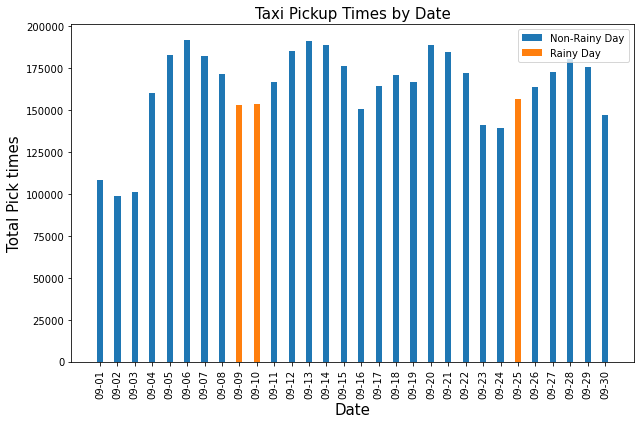

In [23]:
# high light the weekedn days
rain_bar_count = date_count.copy()
for i in range(len(rain_bar_count)):
    if rain_bar_count.index[i] not in ['09-09','09-10', '09-25']:
        rain_bar_count[rain_bar_count.index[i]] = 0


fig, ax = plt.subplots(figsize=(9,6))
work_bar = ax.bar(x, date_count, width, label='Non-Rainy Day')
weekend_bar = ax.bar(x, rain_bar_count, width, label='Rainy Day')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Pick times',fontsize=15)
ax.set_title('Taxi Pickup Times by Date',fontsize=15)
ax.set_xticks(x)
ax.set_xlabel('Date',fontsize=15)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=90)

fig.tight_layout()

plt.show()
fig.savefig('Taxi Pickup Times by Day Rainy.png')

### Business Day or Weekend

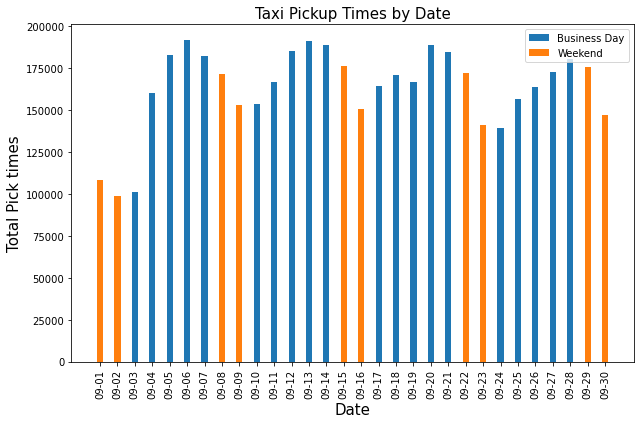

In [24]:
# high light the weekedn days
rain_bar_count = date_count.copy()
for i in range(len(rain_bar_count)):
    if rain_bar_count.index[i] not in ['09-01','09-02', '09-08','09-08','09-09', '09-15','09-16','09-22', '09-23','09-29', '09-30']:
        rain_bar_count[rain_bar_count.index[i]] = 0


fig, ax = plt.subplots(figsize=(9,6))
work_bar = ax.bar(x, date_count, width, label='Business Day')
weekend_bar = ax.bar(x, rain_bar_count, width, label='Weekend')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Pick times',fontsize=15)
ax.set_title('Taxi Pickup Times by Date',fontsize=15)
ax.set_xticks(x)
ax.set_xlabel('Date',fontsize=15)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=90)

fig.tight_layout()

plt.show()
fig.savefig('Taxi Pickup Times by Day weekend.png')

# 2. What will bring taxi drivers more tips in New York?

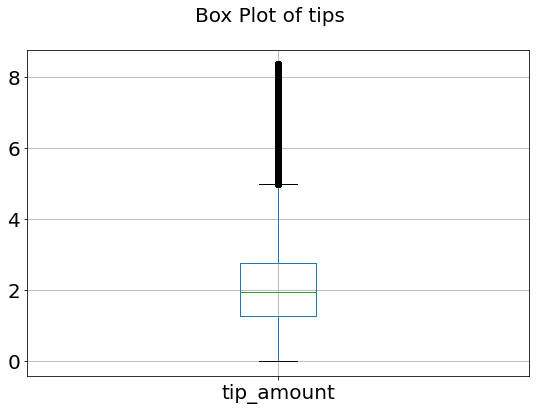

In [25]:

# show the tips after remove outliers
amount_boxplot = full_month.boxplot(column="tip_amount", fontsize=20,figsize=(9,6))
fig = amount_boxplot.get_figure()

fig.suptitle('Box Plot of tips',fontsize=20)
fig.show()
fig.savefig("tips amount after cleaning ourliers.png")


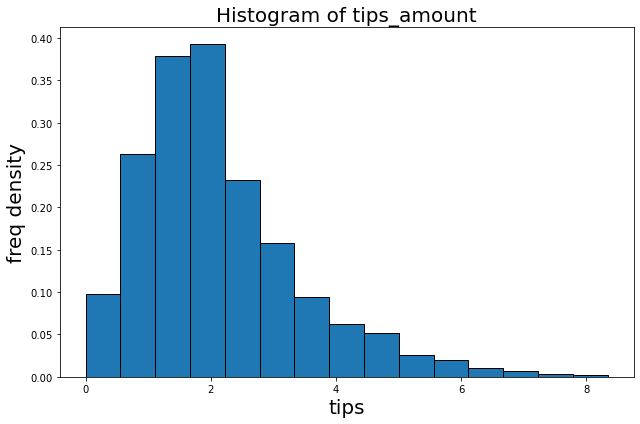

In [26]:
plt.figure(figsize = (9,6))
plt.hist(full_month["tip_amount"],bins = 15,density = True,ec='black')
plt.title('Histogram of tips_amount',fontsize=20)
plt.xlabel('tips',fontsize=20)
plt.ylabel('freq density',fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('histogramtips.png')

## Weather / Date 

In [27]:
tips_count = full_month.groupby("date")["tip_amount"].sum()
date_count = full_month['date'].value_counts().sort_index()
avg_tip = tips_count/date_count

In [28]:
weekend_bar_count = avg_tip.copy()
weekday_bar_count = avg_tip.copy()
rain_bar_count = avg_tip.copy()

In [29]:
for i in range(len(weekend_bar_count)):
    if weekend_bar_count.index[i] not in ['09-05','09-06', '09-12', '09-13','09-19', '09-20','09-26', '09-27']:
        weekend_bar_count[weekend_bar_count.index[i]] = 0

In [30]:
for i in range(len(rain_bar_count)):
    if rain_bar_count.index[i] not in ['09-09','09-10', '09-25']:
        rain_bar_count[rain_bar_count.index[i]] = 0

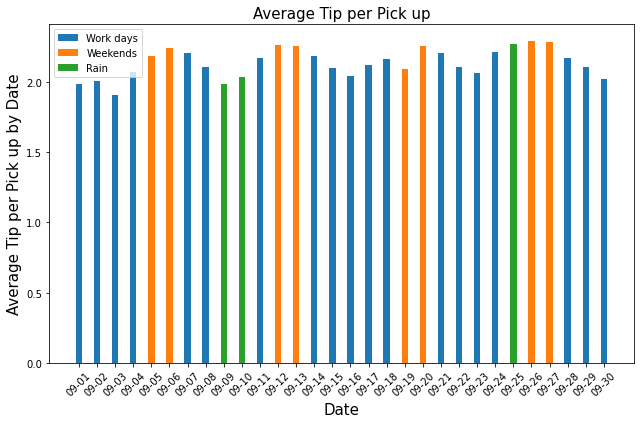

In [31]:
labels = avg_tip.index

x = np.arange(len(labels))  # the label locations

width = 0.35

fig, ax = plt.subplots(figsize=(9,6))

work_bar = ax.bar(x, weekday_bar_count, width, label='Work days')
weekend_bar = ax.bar(x, weekend_bar_count, width, label='Weekends')
rain_bar_cout = ax.bar(x, rain_bar_count, width, label='Rain')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Average Tip per Pick up by Date',fontsize=15)
ax.set_title('Average Tip per Pick up',fontsize=15)
ax.set_xticks(x)
ax.set_xlabel('Date',fontsize=15)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=45)

fig.tight_layout()
plt.show()
plt.close()
plt.style.use('seaborn-white')

 

fig.savefig('avg_tip_per_day.png')

## Weather / Date 

In [32]:
time_count = full_month["Time_h"].value_counts().sort_index()
tips_count = full_month.groupby("Time_h")["tip_amount"].sum()
h_labels = tips_count.index

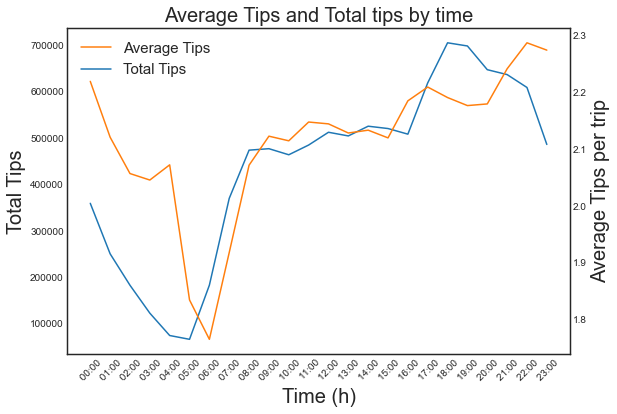

In [33]:
fig, ax = plt.subplots(figsize=(9,6),sharex = True)
ax1 = ax.twinx()



#trip = ax.hist(full_month["Time_h"], 24, alpha=0.5,histtype='bar', ec='black')
avg = ax1.plot((tips_count/time_count),'C1-', label='Average Tips')
total = ax.plot(tips_count,'C0-', label='Total tips')
ax1.set_ylabel(r"Average Tips per trip",fontsize=20)
ax.set_xticklabels(h_labels,rotation= 45) 



ax.legend(avg+total, ["Average Tips","Total Tips"], loc=2,prop={'size': 15})
ax.set_xlabel("Time (h)",fontsize=20)
ax.set_ylabel(r"Total Tips",fontsize=20)
ax.set_title('Average Tips and Total tips by time',fontsize=20)

plt.show()


#ax1.legend(loc = 2)
#ax.legend(loc = 2)
fig.tight_layout()

plt.show()
fig.savefig('Average Tips and Total tips by tim.png')


## Find other possible factors

In [34]:
relation = ["fare_amount","tip_amount","total_amount","trip_distance"]
Sample = full_month.sample(n=int(full_month.shape[0]/100))

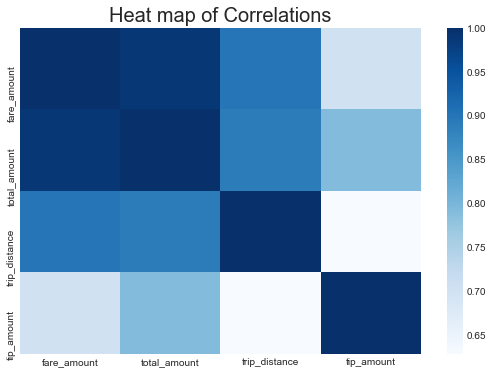

In [35]:
plt.figure(figsize=(9,6))
plt.title("Heat map of Correlations",fontsize=20)
corr = sns.heatmap(cluster_corr(Sample[relation].corr()),cmap="Blues").get_figure()
corr.savefig("correlation.png")

del corr

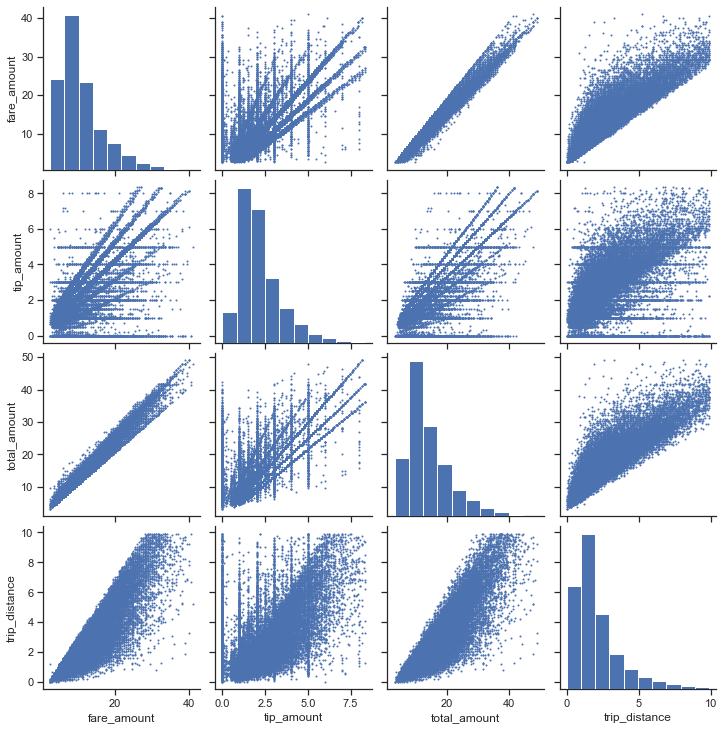

In [36]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(Sample[relation],plot_kws=dict(s=1, edgecolor="b", linewidth=1),)

g.savefig("pair.png")

del g

0.6281826682469694


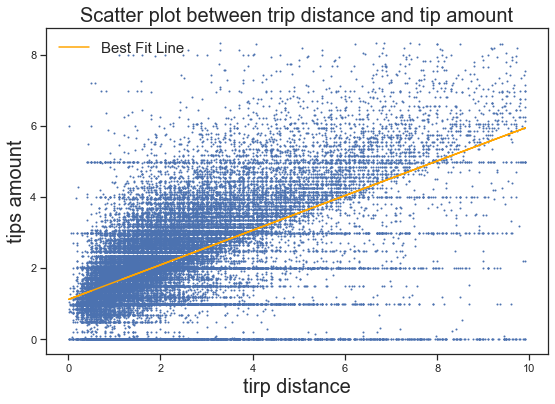

In [37]:
corr = np.corrcoef(Sample["trip_distance"], Sample["tip_amount"])[0][1]
print(corr)

plt.figure(figsize = (9,6))
plt.scatter(Sample["trip_distance"],Sample["tip_amount"],s = 1, alpha =1 )
m, b = np.polyfit(Sample["trip_distance"],Sample["tip_amount"],1)

plt.plot(Sample["trip_distance"], m*Sample["trip_distance"] + b,color='orange',label="Best Fit Line",alpha = 2)
plt.legend(prop={'size': 15})
plt.title('Scatter plot between trip distance and tip amount',fontsize=20)
plt.xlabel('tirp distance',fontsize=20)
plt.ylabel('tips amount',fontsize=20)
plt.show()
fig.savefig('Scatter.png')


### Zone and Tips

In [38]:
tip_region = full_month.groupby("PULocationID")["tip_amount"].sum()/full_month['PULocationID'].value_counts().sort_index()
tip_region = pd.DataFrame({"LocationID":tip_region.index,"tip_region": tip_region})
gdf = gpd.GeoDataFrame(pd.merge(tip_region, sf, left_on='LocationID', right_on='LocationID')).drop('LocationID',axis=1)
top_10 = gdf.sort_values("tip_region",ascending = False)[:10]

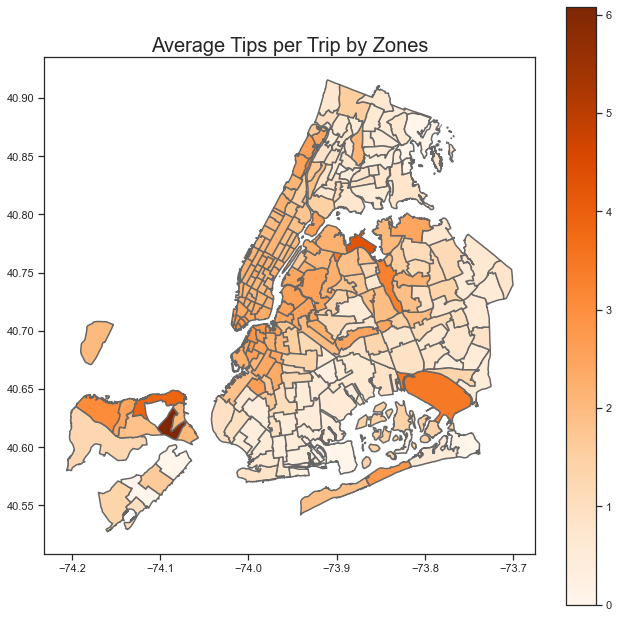

In [39]:
# set the value column that will be visualised
variable = 'tip_region'
# set the range for the choropleth values
vmin, vmax = 0, gdf['tip_region'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(11, 11))

# remove the axis
#ax.axis('off')

# add a title and annotation
ax.set_title("Average Tips per Trip by Zones",  fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)


# create map
gdf.plot(column=variable, cmap='Oranges', linewidth=1.5, ax=ax, edgecolor='0.4')
plt.savefig("Average Tips per Trip by Zones.png")
plt.show()

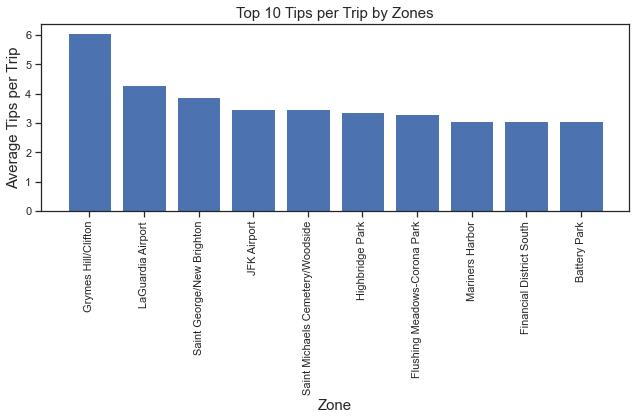

In [40]:
fig, ax = plt.subplots(figsize=(9,6))

ax.bar(top_10["zone"], top_10["tip_region"])


ax.set_ylabel('Average Tips per Trip',fontsize=15)
ax.set_title('Top 10 Tips per Trip by Zones',fontsize=15)
ax.set_xlabel('Zone',fontsize=15)

ax.set_xticklabels(top_10["zone"].values)
ax.set_xticks(top_10["zone"].values)
#ax.set_xticklabels(top_10["zone"].values)
plt.xticks(rotation=90)

fig.tight_layout()
plt.show()
plt.close()
plt.style.use('seaborn-white')

 

fig.savefig('Top 10 Tips per Trip by Zones.png')

# Add some text for labels, title and custom x-axis tick labels, etc.
